In [11]:
import sys
sys.path.insert(0, '../src')
sys.path.insert(0, '../data')

import functions
import plot
import clean
import models
import imports



sns.set()

SyntaxError: invalid syntax (imports.py, line 28)

In [572]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import plotly.express as px
# import scipy.stats as stats
# import statsmodels.api as sm

# from pandas.plotting import scatter_matrix
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
# from sklearn.datasets import make_classification
# from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, auc
# from sklearn.preprocessing import Normalizer
# from sklearn import metrics

# import sys
# sys.path.insert(0, '../src')
# sys.path.insert(0, '../data')

# import functions
# import plot
# import clean
# import models

# %load_ext autoreload
# %autoreload 2

sns.set()

seed = 8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [573]:
columns = ['DEP', 'PT', 'AGE', 'GT', 'EL', 'SC', 'CO', 'FA', 'ST']

## Data Import & Cleaning

Psychological Operations Assessment and Selection (POAS)

In [574]:
poas_filepath = '../data/poas'
poas_filenames = ['poas16.xlsx', 'poas17.xlsx', 'poas18.xlsx', 'poas19.xlsx', 'poas20.xlsx', 'poas21.xlsx', 'poas22.xlsx']


poas = clean.clean_data(poas_filepath, poas_filenames, columns, 'POAS')
poas.to_excel('../data/poas/poas.xlsx', index=False)

/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


Special Forces Assesment and Selection (SFAS)

In [575]:
sfas_filepath = '../data/sfas'
sfas_filenames = ['sfas16.xlsx', 'sfas17.xlsx', 'sfas18.xlsx', 'sfas19.xlsx', 'sfas20.xlsx', 'sfas21.xlsx', 'sfas22.xlsx']

sfas = clean.clean_data(sfas_filepath, sfas_filenames, columns, 'SFAS')
poas.to_excel('../data/sfas/sfas.xlsx', index=False)

/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():


## Initial Overview

View of overall data

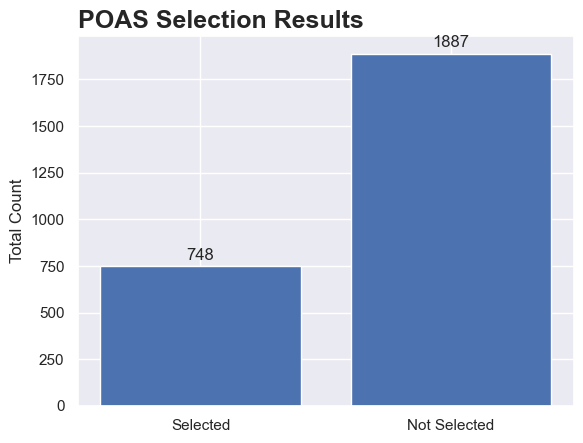

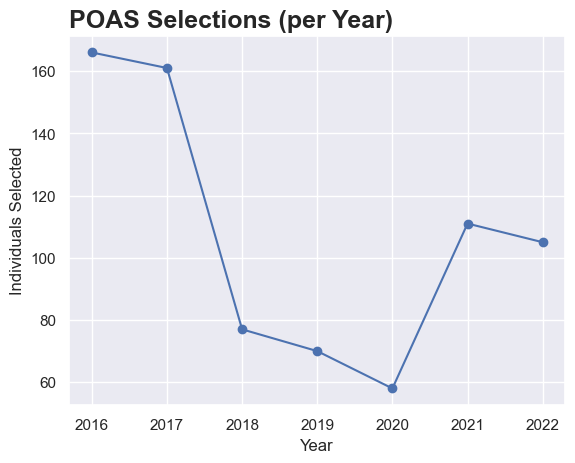

In [576]:
poas_selected = functions.equal_column_val(poas, 'RESULT', 'SELECTED')
poas_not_selected = functions.not_column_val(poas, 'RESULT', 'SELECTED')

outcome = [poas_selected.RESULT.count(), poas_not_selected.RESULT.count()]


plot.select_bar_plot(outcome, ['Selected', 'Not Selected'] , 'POAS Selection Results', 'Total Count')



plot.annual_line_plot(poas_selected, 'POAS Selections (per Year)', 'Year', 'Individuals Selected')







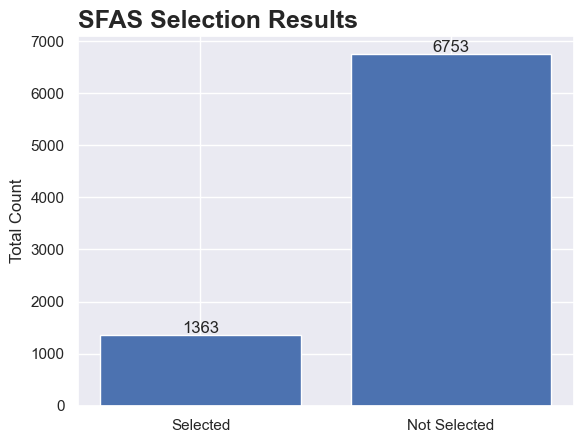

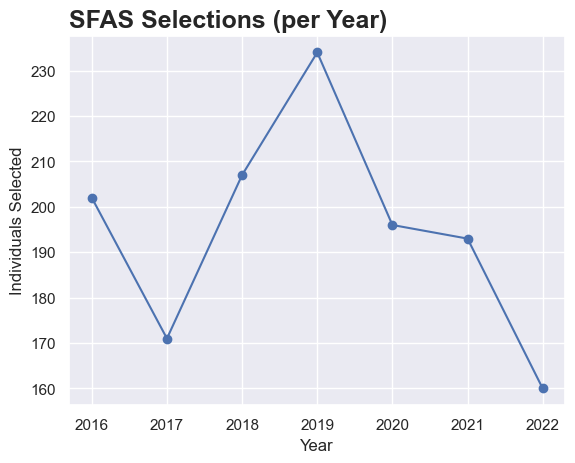

In [577]:
sfas_selected = functions.equal_column_val(sfas, 'RESULT', 'SELECTED')
sfas_not_selected = functions.not_column_val(sfas, 'RESULT', 'SELECTED')
outcome = [sfas_selected.RESULT.count(), sfas_not_selected.RESULT.count()]


plot.select_bar_plot(outcome, ['Selected', 'Not Selected'] , 'SFAS Selection Results', 'Total Count')
plot.annual_line_plot(sfas_selected, 'SFAS Selections (per Year)', 'Year', 'Individuals Selected')

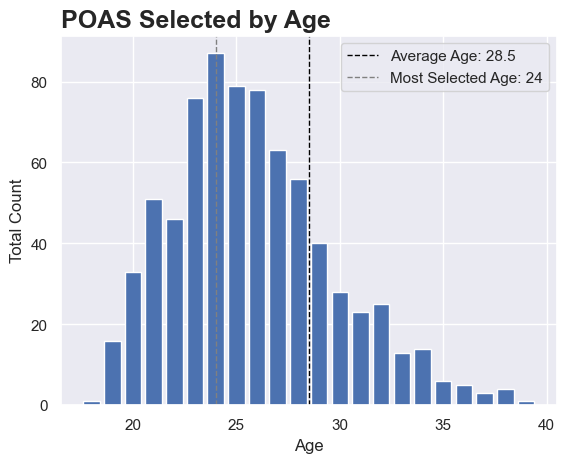

In [578]:
poas_ages = poas_selected.groupby('AGE').size().reset_index(name='counts')
poas_avg_age = poas_ages.mean()
poas_most_age = poas_ages.loc[poas_ages['counts'].idxmax(), 'AGE']

plot.age_bar_plot(poas_ages['AGE'], poas_ages['counts'], 'POAS Selected by Age', 'Age', 'Total Count', poas_avg_age[0], poas_most_age)

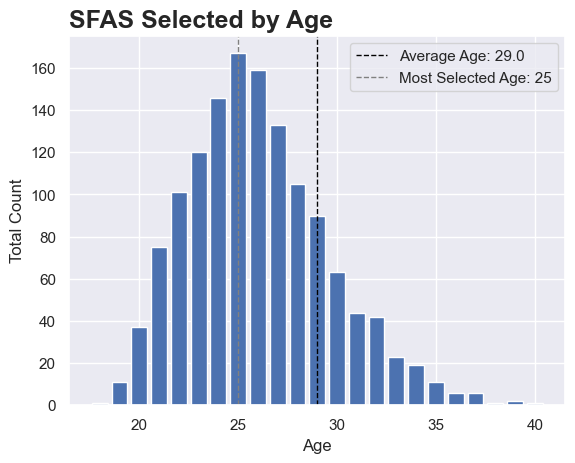

In [579]:
sfas_ages = sfas_selected.groupby('AGE').size().reset_index(name='counts')
sfas_avg_age = sfas_ages.mean()
sfas_most_age = sfas_ages.loc[sfas_ages['counts'].idxmax(), 'AGE']

plot.age_bar_plot(sfas_ages['AGE'], sfas_ages['counts'], 'SFAS Selected by Age', 'Age', 'Total Count', sfas_avg_age[0], sfas_most_age)

## Key Features

Numerical look at features that are often considered "important"

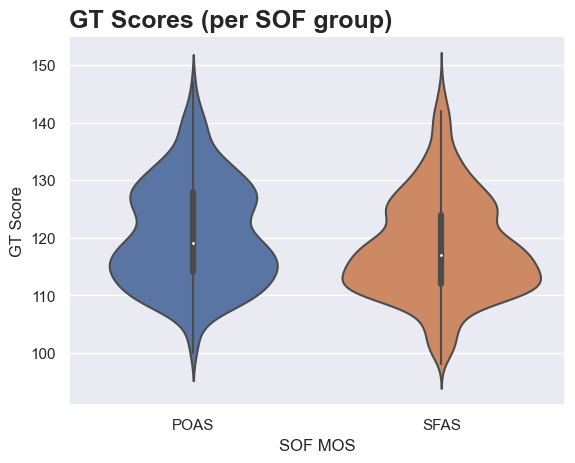

In [580]:
both = [poas, sfas]
combined = functions.combined(both)
combined_selected = functions.equal_column_val(combined, 'RESULT', 'SELECTED')

plot.violin_plot('GROUP', 'GT', combined_selected, 'GT Scores (per SOF group)', 'SOF MOS', 'GT Score')

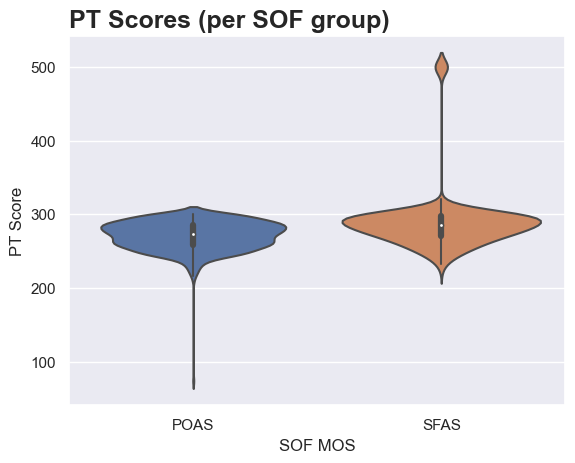

In [581]:
plot.violin_plot('GROUP', 'PT', combined_selected, 'PT Scores (per SOF group)', 'SOF MOS', 'PT Score')

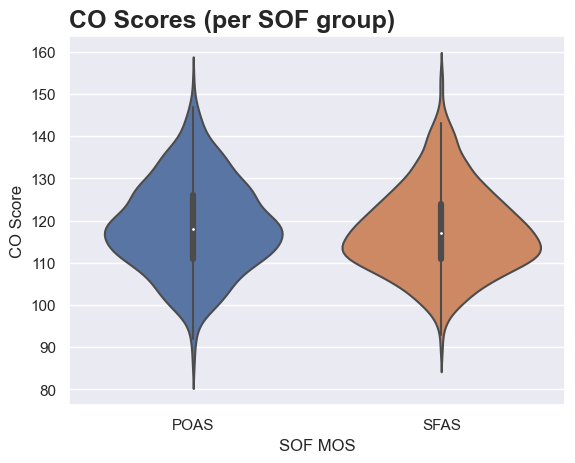

In [582]:
plot.violin_plot('GROUP', 'CO', combined_selected, 'CO Scores (per SOF group)', 'SOF MOS', 'CO Score')

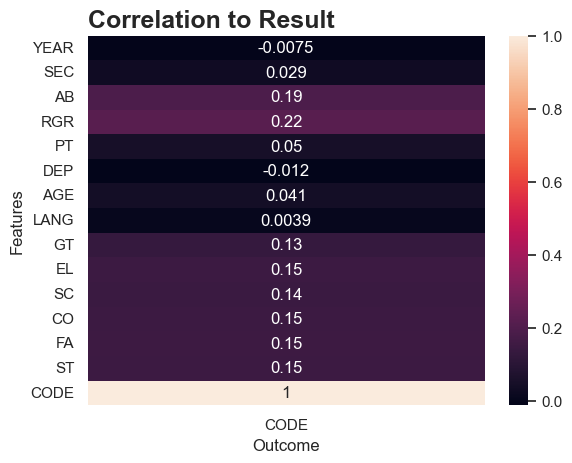

In [583]:
corr_matrix = combined.corr().loc[:, ['CODE']]

# fig, ax = plt.subplots()
# sns.heatmap(corr_matrix, annot=True, ax=ax)
# plt.tight_layout()
# ax.set_title('TEST')

plot.select_correlation(combined, 'Correlation to Result', 'Outcome', 'Features')

In [584]:
split = functions.split_combined(combined)


## POAS Pre-Model

In [585]:
rank_vals = {'PV2': 2, 'PFC': 3, 'CPL': 4, 'SPC': 4, 'SGT': 5, 'SSG': 6}
poas.RANK = poas.RANK.replace(rank_vals)
poas2 = poas.drop(['YEAR', 'RACE', 'MOS', 'ED', 'MARITAL', 'RESULT', 'GROUP'], axis=1)

In [586]:
poasX = poas2.drop('CODE', axis=1)
poasy = poas2.CODE

poasX2 = Normalizer().fit_transform(poasX)


## POAS Info

In [587]:
poas_X_train, poas_X_test, poas_y_train, poas_y_test = train_test_split(poasX2, poasy, test_size=.2, stratify=poasy, random_state=seed)

In [588]:
poas_info = sm.OLS(poas_y_train, poas_X_train).fit()
print(poas_info.summary())

                                 OLS Regression Results                                
Dep. Variable:                   CODE   R-squared (uncentered):                   0.324
Model:                            OLS   Adj. R-squared (uncentered):              0.319
Method:                 Least Squares   F-statistic:                              66.93
Date:                Wed, 01 Feb 2023   Prob (F-statistic):                   1.30e-165
Time:                        17:55:29   Log-Likelihood:                         -1250.2
No. Observations:                2108   AIC:                                      2530.
Df Residuals:                    2093   BIC:                                      2615.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## POAS Logistic Regression Model

Single Logistic Regression Model

Test accuracy: 53.32%
Test precision: 0.31
Test recall: 0.51


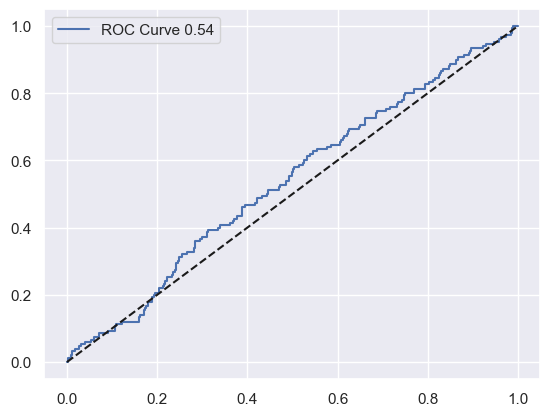

In [589]:
poas_single_model = models.regression_model(poas_X_train, poas_X_test, poas_y_train, poas_y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Mean Accuracy: 60.34%
Mean Precision: 0.38
Mean Recall: 0.60


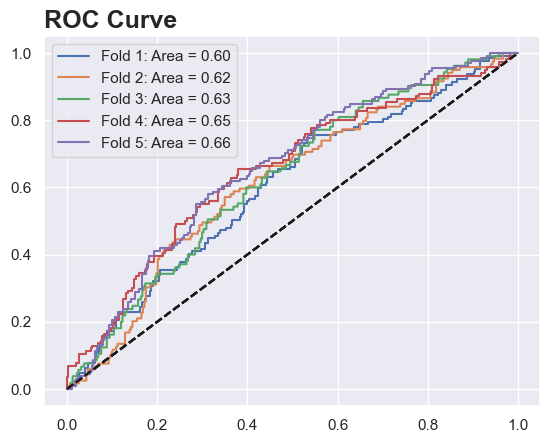

In [601]:
poas_multi = models.multiple_regression_model(poasX, poasy, 5)

## SFAS Pre-Model


In [591]:
rank_vals = {'PV2': 2, 'PFC': 3, 'CPL': 4, 'SPC': 4, 'SGT': 5, 'SSG': 6, 'SFC': 7, 'SSGT': 6, 'SRA': 4, 'SN': 3, 'AF': 4}
sfas.RANK = sfas.RANK.replace(rank_vals)
sfas2 = sfas.drop(['YEAR', 'RACE', 'MOS', 'ED', 'MARITAL', 'RESULT', 'GROUP'], axis=1)

In [592]:
sfasX = sfas2.drop('CODE', axis=1)
sfasy = sfas2.CODE

sfasX2 = Normalizer().fit_transform(sfasX)

## SFAS Info

In [593]:
sfas_X_train, sfas_X_test, sfas_y_train, sfas_y_test = train_test_split(sfasX2, sfasy, test_size=.2, stratify=sfasy, random_state=seed)
sfas_info = sm.OLS(sfas_y_train, sfas_X_train).fit()
print(sfas_info.summary())

                                 OLS Regression Results                                
Dep. Variable:                   CODE   R-squared (uncentered):                   0.255
Model:                            OLS   Adj. R-squared (uncentered):              0.253
Method:                 Least Squares   F-statistic:                              147.7
Date:                Wed, 01 Feb 2023   Prob (F-statistic):                        0.00
Time:                        17:55:30   Log-Likelihood:                         -2464.9
No. Observations:                6492   AIC:                                      4960.
Df Residuals:                    6477   BIC:                                      5061.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## SFAS Logistic Regression Model

Single Logistic Regression Model

Test accuracy: 55.60%
Test precision: 0.33
Test recall: 0.53


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


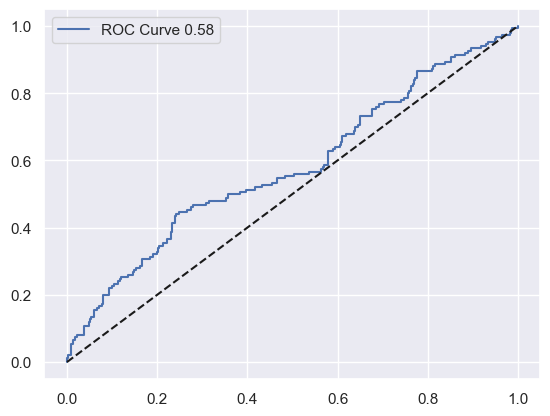

In [594]:
sfas_single_model = models.regression_model(X_train, X_test, y_train, y_test)


Multiple Models using KFolds

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.6896216243145432
0.28747783607486377
0.5709281885762673


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


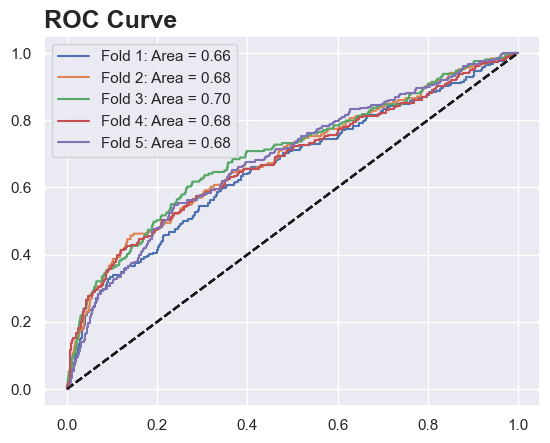

In [598]:
sfas_multi = models.multiple_regression_model(sfasX, sfasy, 5)